# Nhóm 12: Hệ thống giám sát, dự đoán, cảnh báo không khí có khả năng cháy nổ

## Thành viên trong nhóm:

* N21DCCN006 - Nguyễn Duy Bảo
* N21DCCN030 - Bùi Quang Hiệp
* N21DCCN071 - Nguyễn Bá Sang
* N21DCCN096 - Huỳnh Như Ý

## Note:Nhóm tụi em mỗi 5s là sẽ lấy một dòng dữ liệu từ Sensor ạ.

In [1]:
import pandas as pd

file_path = "data.csv" 
df = pd.read_csv(file_path)

# Kiểm tra dữ liệu
print(df.head())
print(len(df))

print("\nKhoảng giá trị của từng cột:")
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):  # Chỉ xét các cột số
        min_val = df[column].min()
        max_val = df[column].max()
        print(f"{column}: [{min_val}, {max_val}]")

   Temperature[C]  Humidity[%]  Pressure[hPa]  CO(V)  Fire Alarm
0          20.000        57.36        939.735  0.351           0
1          20.015        56.67        939.744  0.391           0
2          20.029        55.96        939.738  0.749           0
3          20.044        55.28        939.736  0.381           0
4          20.059        54.69        939.744  0.394           0
62630

Khoảng giá trị của từng cột:
Temperature[C]: [-22.01, 59.93]
Humidity[%]: [10.74, 75.2]
Pressure[hPa]: [930.852, 939.861]
CO(V): [0.0, 1.0]
Fire Alarm: [0, 1]


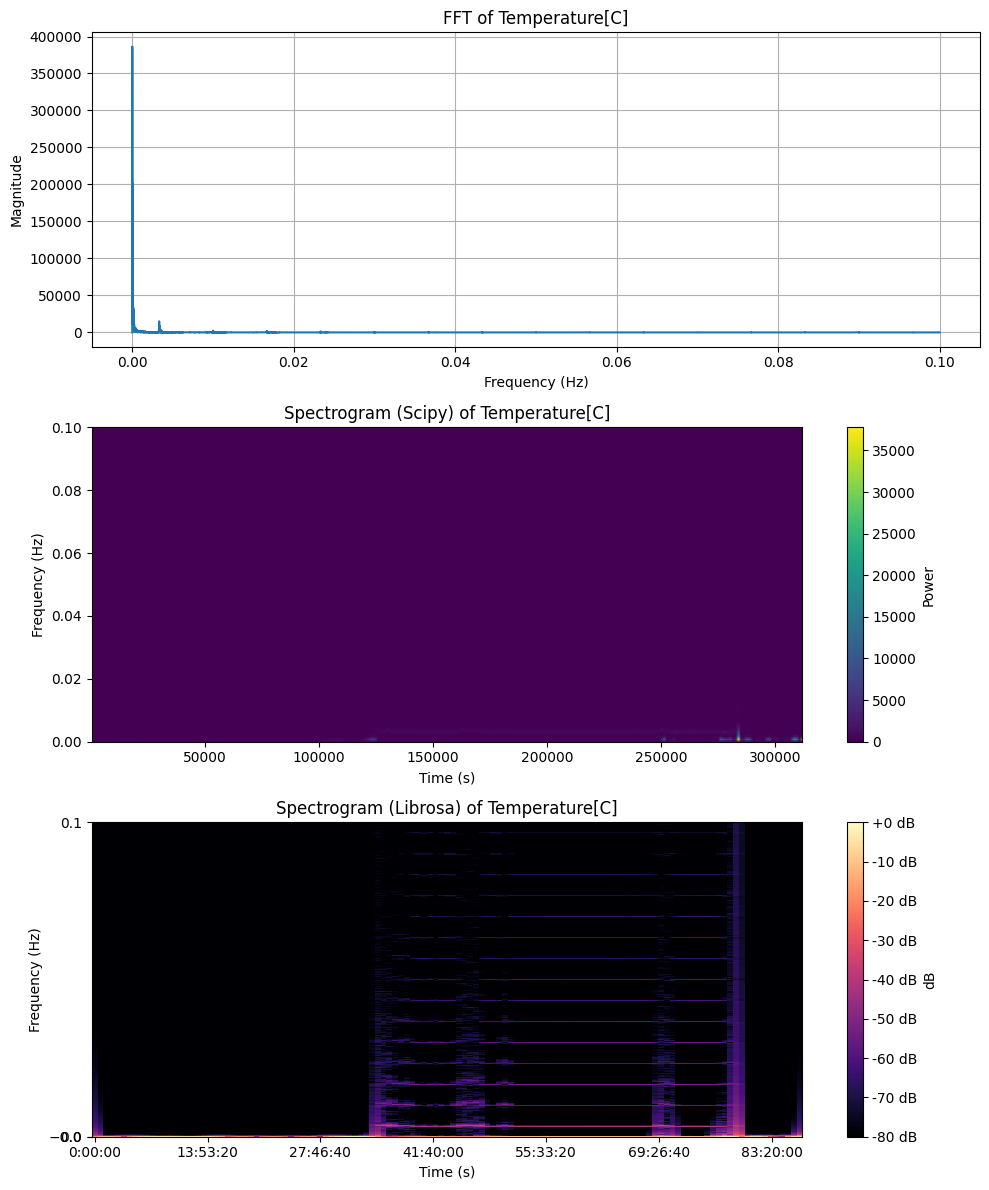

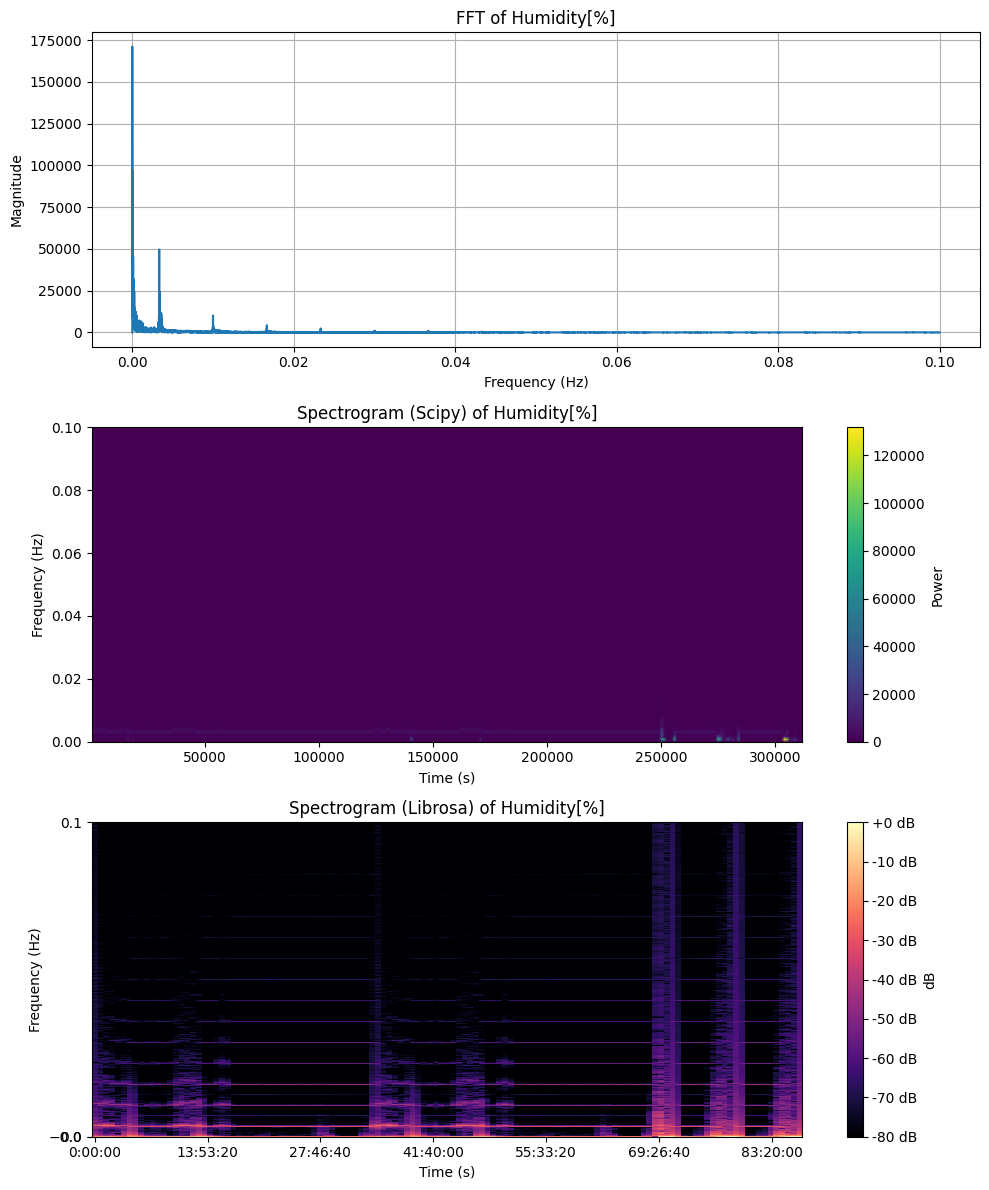

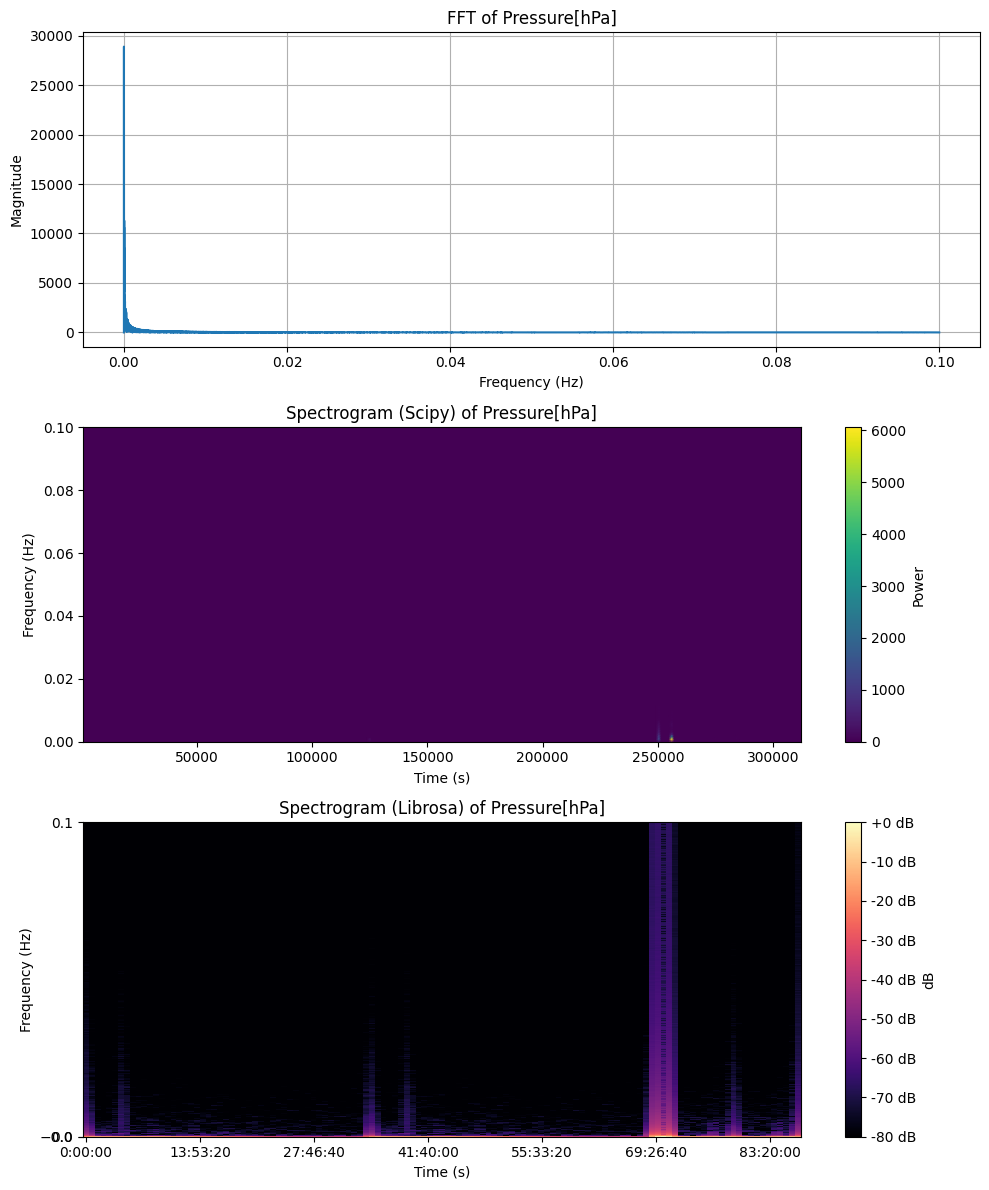

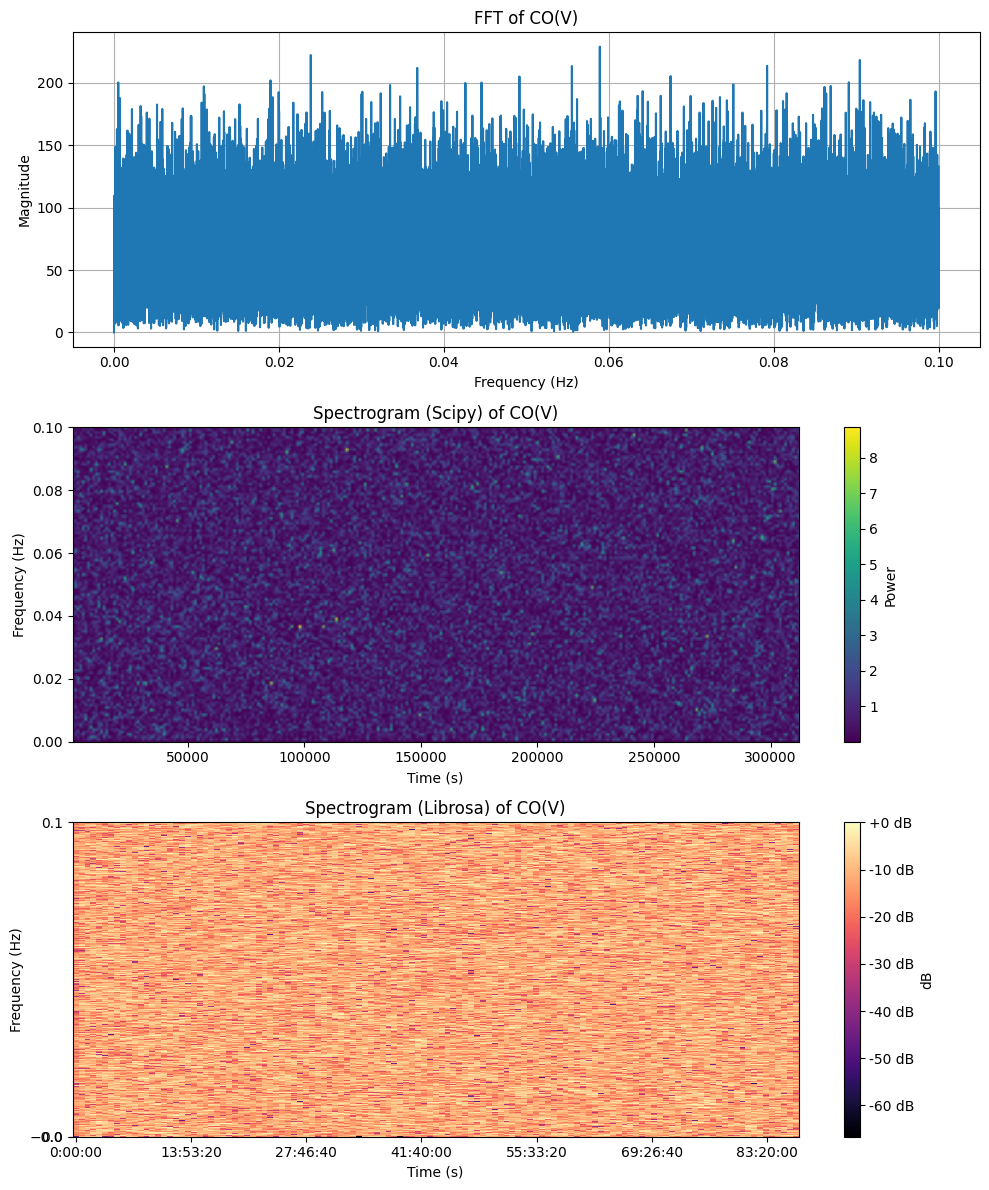

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.fftpack import fft
from scipy.signal import spectrogram


# Xác định danh sách cột dữ liệu cảm biến
sensor_columns = ['Temperature[C]', 'Humidity[%]', 'Pressure[hPa]', 'CO(V)']
fs = 1/5  # Tần số lấy mẫu 5 giây (0.2Hz)

for column in sensor_columns:
    signal = df[column].values
    signal = signal - np.mean(signal)  # Loại bỏ đi thành phần trung bình để tập trung vào thành phần dao động.
    N = len(signal)
    
    # FFT
    fft_values = fft(signal)
    freqs = np.fft.fftfreq(N, d=1/fs)
    
    # Spectrogram với scipy
    f_scipy, t_scipy, Sxx_scipy = spectrogram(signal, fs)
    
    # Spectrogram với librosa
    Sxx_librosa = librosa.stft(signal)
    Sxx_librosa_db = librosa.amplitude_to_db(np.abs(Sxx_librosa), ref=np.max)
    
    # Vẽ kết quả
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    
    # Biểu đồ FFT
    axs[0].plot(freqs[:N//2], np.abs(fft_values[:N//2]))
    axs[0].set_title(f'FFT of {column}')
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_ylabel('Magnitude')
    axs[0].grid()
    
    # Biểu đồ Spectrogram với scipy
    pcm = axs[1].pcolormesh(t_scipy, f_scipy, Sxx_scipy, shading='gouraud')
    axs[1].set_title(f'Spectrogram (Scipy) of {column}')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Frequency (Hz)')
    axs[1].set_ylim([0, fs/2])
    fig.colorbar(pcm, ax=axs[1], label='Power')
    
    # Biểu đồ Spectrogram với librosa
    img = librosa.display.specshow(Sxx_librosa_db, sr=fs, x_axis='time', y_axis='log', ax=axs[2])
    axs[2].set_title(f'Spectrogram (Librosa) of {column}')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Frequency (Hz)')
    cbar = fig.colorbar(img, ax=axs[2], format='%+2.0f dB')
    cbar.set_label('dB')
    
    plt.tight_layout()
    plt.show()